# ImageNet and Transfer Learning

In this tutorial we'll train a model on the [ImageNet](http://www.image-net.org/) dataset. Unfortunately we can't train on the full version of ImageNet due to space constraints on Colab so I've made a version of the dataset where each image is resized much smaller (the shorter size is no larger than 64 pixels).

After we train our classifier we'll do some **transfer learning** by fine tuning a similar model with the pretrained weights on a different dataset (in this case CIFAR-10).

## Image Classification on ImageNet

The full ImageNet dataset has about 14 million images and ~22,000 categories but it is very noisy, imbalanced, and has a number of other issues.

The version of ImageNet we'll be using has 1.2 million images and 1,000 classes (known as the competition/2012/ILSVRC2012 version, it is the most common subset to use). It still has lots of issues but it's more practical to train on.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### ImageNet Dataset

#### Connecting Google Drive

For this tutorial we'll use Google Drive to store the dataset and checkpoints of the model during training. Training on ImageNet takes a long time and Colab might restart or we may have issues so it's important to save intermediate versions of our model during training to make sure we don't lose anything.

The following commands connect to Google Drive and set up the folder to hold files for this project under the `checkpoints` variable, you can change the path if you want.

```
# This is formatted as code
```



In [8]:
# import os
# from google.colab import drive
# drive.mount('/content/drive')
checkpoints = 'test'
# if not os.path.exists(checkpoints):
#     os.makedirs(checkpoints)

In [ ]:
%cd '/content/drive/Shareddrives/AR-mirror/598Stella/checkpoints'

/content/drive/Shareddrives/AR-mirror/598Stella/checkpoints


In [ ]:
!ls /content/drive/MyDrive/colab_files/imagenet64

checkpoint-19.pkl


#### Downloading ImageNet64

If you don't have it downloaded already this will download ImageNet to your Google Drive folder, copy it to the local environment, and then extract it.

In [2]:
!wget https://pjreddie.com/media/files/imagenet64.tar

--2023-04-23 14:15:44--  https://pjreddie.com/media/files/imagenet64.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10033909760 (9.3G) [application/octet-stream]
Saving to: ‘imagenet64.tar’

imagenet64.tar      100%[===================>]   9.34G  18.1MB/s    in 11m 26s 

2023-04-23 14:27:11 (13.9 MB/s) - ‘imagenet64.tar’ saved [10033909760/10033909760]



In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

In [5]:
!tar -xf imagenet64.tar
print("Data ready!")

Data ready!


In [12]:
%cd imagenet64/

/content/imagenet64


In [14]:
import os
print(len(next(os.walk('val'))[1]))

1000


In [16]:
%cd ..

/content


#### Dataset Definition

This is similar to previous versions of our dataset definition although this time we are using the `torchvision.datasets.ImageFolder` helper function, you can read more in the [PyTorch docs](https://pytorch.org/vision/0.8/datasets.html#imagefolder). This function allows us to easily connect any image dataset to PyTorch that is split up into classes by subfolder (which fortunately our dataset is!)

In [6]:
def get_imagenet64_data():
  # Data augmentation transformations. Not for Testing!
  transform_train = transforms.Compose([
    transforms.Resize([224,224]), # Takes images smaller than 64 and enlarges them
    #transforms.RandomCrop(64, padding=4, padding_mode='edge'), # Take 64x64 crops from 72x72 padded images
    transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
  ])

  transform_test = transforms.Compose([
      transforms.Resize([224,224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
  ])

  trainset = torchvision.datasets.ImageFolder(root='./imagenet64/train/', transform=transform_train)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

  testset = torchvision.datasets.ImageFolder(root='./imagenet64/val/', transform=transform_test)
  testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

  return {'train': trainloader, 'test': testloader}

data = get_imagenet64_data()

#### Visualizing ImageNet Data

Let's see what we got!

torch.Size([8, 3, 224, 224])


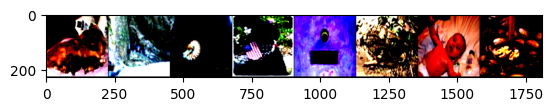

Labels:tensor(154) tensor(119) tensor(117) tensor(206) tensor(637) tensor(41) tensor(529) tensor(910)
torch.Size([8, 3, 224, 224])
torch.Size([8, 150528])


In [7]:
dataiter = iter(data['train'])
images, labels = next(dataiter)
images = images[:8]
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ' '.join('%9s' % labels[j] for j in range(8)))

flat = torch.flatten(images, 1)
print(images.size())
print(flat.size())

### Classification Model

This model is a modification of the [Darknet Reference Network](https://pjreddie.com/darknet/imagenet/#reference) to fit the smaller size of our dataset (`64x64` images instead of `256x256`). It has successive `3x3` convolutional layers with maxpooling ending with a global average pooling and fully connected layer.

One note, since we are using batch normalization we can turn off the biases in the convolutional layers, `nn.BatchNorm2d` has biases built in and the mean subtraction would undo any bias from the convolutional layer.

In [17]:
#ResNet+CBAM
import torch.nn as nn
import math
try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url
import torch

__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)



class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1   = nn.Conv2d(in_planes, in_planes // 16, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)


        # self.ca = ChannelAttention(planes)
        # self.sa = SpatialAttention()

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # out = self.ca(out) * out
        # out = self.sa(out) * out


        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)

        # self.ca = ChannelAttention(planes * self.expansion)
        # self.sa = SpatialAttention()

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        # out = self.ca(out) * out
        # out = self.sa(out) * out

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)

        # 网络的第一层加入注意力机制
        self.ca = ChannelAttention(self.inplanes)
        self.sa = SpatialAttention()

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        # 网络的卷积层的最后一层加入注意力机制
        self.ca1 = ChannelAttention(self.inplanes)
        self.sa1 = SpatialAttention()

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.ca(x) * x
        x = self.sa(x) * x

        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.ca1(x) * x
        x = self.sa1(x) * x


        x = self.avgpool(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)

        return x


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        # state_dict = load_state_dict_from_url(model_urls[arch],
        #                                       progress=progress)
        state_dict = torch.load('imagenet64_cbam_30.pth')
        new_state_dict = model.state_dict()
        new_state_dict.update(state_dict)
        model.load_state_dict(new_state_dict)
    return model



def resnet18(pretrained=False, progress=True, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


def resnet34(pretrained=False, progress=True, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained=False, progress=True, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet101(pretrained=False, progress=True, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)


def resnet152(pretrained=False, progress=True, **kwargs):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)


def resnext50_32x4d(pretrained=False, progress=True, **kwargs):
    """Constructs a ResNeXt-50 32x4d model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def resnext101_32x8d(pretrained=False, progress=True, **kwargs):
    """Constructs a ResNeXt-101 32x8d model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)

### Training

The training function is similar to past versions with some updates. In particular, now there is a `schedule` parameter to handle learning rate scheduling and also a `checkpoint_path` parameter which will be where training checkpoints are saved (if provided).

The core of training is the same though, get a batch, run the model forward, calculate loss, run it backward, update.

In [9]:
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
  net.to(device)
  net.train()
  losses = []
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

  # Load previous training state
  if state:
      net.load_state_dict(state['net'])
      optimizer.load_state_dict(state['optimizer'])
      start_epoch = state['epoch']
      losses = state['losses']

  # Fast forward lr schedule through already trained epochs
  for epoch in range(start_epoch):
    if epoch in schedule:
      print ("Learning rate: %f"% schedule[epoch])
      for g in optimizer.param_groups:
        g['lr'] = schedule[epoch]

  for epoch in range(start_epoch, epochs):
    sum_loss = 0.0

    # Update learning rate when scheduled
    if epoch in schedule:
      print ("Learning rate: %f"% schedule[epoch])
      for g in optimizer.param_groups:
        g['lr'] = schedule[epoch]

    for i, batch in enumerate(dataloader, 0):
        inputs, labels = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # autograd magic, computes all the partial derivatives
        optimizer.step() # takes a step in gradient direction

        losses.append(loss.item())
        sum_loss += loss.item()
        
        if i % print_every == print_every-1:    # print every 10 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
            sum_loss = 0.0
    if checkpoint_path:
      state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
      torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
  return losses

def accuracy(net, dataloader):
  net.to(device)
  net.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch[0].to(device), batch[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total

def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

#### Training From Scratch

To start off training we can just create a model and invoke our training command. **Note** this will take a while, maybe overnight, to finish training!

In this case we are training with a learning rate schedule:
- The first 5 epochs at 0.1
- Then 10 epochs at 0.01
- Then 5 more at 0.001

I just sort of made the schedule up so you can try different things if you want!

In [ ]:
#ResNet
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
# model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
# model.maxpool = nn.Identity()
# model = model.to(device)

#ResNet+CBAM
model = resnet18(pretrained=True, progress = True)
# model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
# model.maxpool = nn.Identity()
model = model.to(device)
losses = train(model, data['train'], epochs=10, schedule={0:.001, 5:.0005, 15:.0001}, checkpoint_path=None)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Learning rate: 0.001000
[0,    10] loss: 1.270
[0,    20] loss: 1.248
[0,    30] loss: 1.264
[0,    40] loss: 1.279
[0,    50] loss: 1.213
[0,    60] loss: 1.152
[0,    70] loss: 1.224
[0,    80] loss: 1.180
[0,    90] loss: 1.245
[0,   100] loss: 1.176
[0,   110] loss: 1.136
[0,   120] loss: 1.293
[0,   130] loss: 1.276
[0,   140] loss: 1.247
[0,   150] loss: 1.261
[0,   160] loss: 1.303
[0,   170] loss: 1.310
[0,   180] loss: 1.275
[0,   190] loss: 1.193
[0,   200] loss: 1.212
[0,   210] loss: 1.234
[0,   220] loss: 1.236
[0,   230] loss: 1.214
[0,   240] loss: 1.255
[0,   250] loss: 1.269
[0,   260] loss: 1.252
[0,   270] loss: 1.246
[0,   280] loss: 1.292
[0,   290] loss: 1.245
[0,   300] loss: 1.314
[0,   310] loss: 1.337
[0,   320] loss: 1.114
[0,   330] loss: 1.238
[0,   340] loss: 1.240
[0,   350] loss: 1.203
[0,   360] loss: 1.260
[0,   370] loss: 1.200
[0,   380] loss: 1.313
[0,   390] loss: 1.258
[0,   400] loss: 1.189
[0,   410] loss: 1.275
[0,   420] loss: 1.213
[0,   430]

/usr/local/lib/python3.9/dist-packages/PIL/TiffImagePlugin.py:625: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[0,  4860] loss: 1.355
[0,  4870] loss: 1.279
[0,  4880] loss: 1.271
[0,  4890] loss: 1.286
[0,  4900] loss: 1.273
[0,  4910] loss: 1.328
[0,  4920] loss: 1.266
[0,  4930] loss: 1.368
[0,  4940] loss: 1.295
[0,  4950] loss: 1.357
[0,  4960] loss: 1.250
[0,  4970] loss: 1.349
[0,  4980] loss: 1.321
[0,  4990] loss: 1.267
[0,  5000] loss: 1.262
[0,  5010] loss: 1.268
[0,  5020] loss: 1.300
[0,  5030] loss: 1.329
[0,  5040] loss: 1.236
[0,  5050] loss: 1.277
[0,  5060] loss: 1.370
[0,  5070] loss: 1.295
[0,  5080] loss: 1.274
[0,  5090] loss: 1.304
[0,  5100] loss: 1.346
[0,  5110] loss: 1.388
[0,  5120] loss: 1.285
[0,  5130] loss: 1.333
[0,  5140] loss: 1.322
[0,  5150] loss: 1.225
[0,  5160] loss: 1.315
[0,  5170] loss: 1.259
[0,  5180] loss: 1.276
[0,  5190] loss: 1.305
[0,  5200] loss: 1.279
[0,  5210] loss: 1.303
[0,  5220] loss: 1.242
[0,  5230] loss: 1.349
[0,  5240] loss: 1.351
[0,  5250] loss: 1.313
[0,  5260] loss: 1.269
[0,  5270] loss: 1.316
[0,  5280] loss: 1.354
[0,  5290] 

/usr/local/lib/python3.9/dist-packages/PIL/TiffImagePlugin.py:625: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[1,  5910] loss: 1.213
[1,  5920] loss: 1.291
[1,  5930] loss: 1.242
[1,  5940] loss: 1.251
[1,  5950] loss: 1.284
[1,  5960] loss: 1.274
[1,  5970] loss: 1.250
[1,  5980] loss: 1.303
[1,  5990] loss: 1.298
[1,  6000] loss: 1.331
[1,  6010] loss: 1.277
[1,  6020] loss: 1.326
[1,  6030] loss: 1.319
[1,  6040] loss: 1.242
[1,  6050] loss: 1.281
[1,  6060] loss: 1.258
[1,  6070] loss: 1.323
[1,  6080] loss: 1.288
[1,  6090] loss: 1.280
[1,  6100] loss: 1.277
[1,  6110] loss: 1.303
[1,  6120] loss: 1.253
[1,  6130] loss: 1.255
[1,  6140] loss: 1.260
[1,  6150] loss: 1.253
[1,  6160] loss: 1.244
[1,  6170] loss: 1.361
[1,  6180] loss: 1.317
[1,  6190] loss: 1.285
[1,  6200] loss: 1.244
[1,  6210] loss: 1.350
[1,  6220] loss: 1.307
[1,  6230] loss: 1.263
[1,  6240] loss: 1.298
[1,  6250] loss: 1.275
[1,  6260] loss: 1.276
[1,  6270] loss: 1.292
[1,  6280] loss: 1.283
[1,  6290] loss: 1.317
[1,  6300] loss: 1.314
[1,  6310] loss: 1.259
[1,  6320] loss: 1.219
[1,  6330] loss: 1.301
[1,  6340] 

/usr/local/lib/python3.9/dist-packages/PIL/TiffImagePlugin.py:625: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[1,  9340] loss: 1.329
[1,  9350] loss: 1.337
[1,  9360] loss: 1.309
[1,  9370] loss: 1.316
[1,  9380] loss: 1.288
[1,  9390] loss: 1.295
[1,  9400] loss: 1.337
[1,  9410] loss: 1.479
[1,  9420] loss: 1.308
[1,  9430] loss: 1.278
[1,  9440] loss: 1.225
[1,  9450] loss: 1.411
[1,  9460] loss: 1.282
[1,  9470] loss: 1.274
[1,  9480] loss: 1.317
[1,  9490] loss: 1.364
[1,  9500] loss: 1.323
[1,  9510] loss: 1.339
[1,  9520] loss: 1.415
[1,  9530] loss: 1.273
[1,  9540] loss: 1.302
[1,  9550] loss: 1.269
[1,  9560] loss: 1.309
[1,  9570] loss: 1.243
[1,  9580] loss: 1.338
[1,  9590] loss: 1.374
[1,  9600] loss: 1.242
[1,  9610] loss: 1.273
[1,  9620] loss: 1.311
[1,  9630] loss: 1.312
[1,  9640] loss: 1.349
[1,  9650] loss: 1.317
[1,  9660] loss: 1.248
[1,  9670] loss: 1.294
[1,  9680] loss: 1.254
[1,  9690] loss: 1.288
[1,  9700] loss: 1.280
[1,  9710] loss: 1.212
[1,  9720] loss: 1.268
[1,  9730] loss: 1.335
[1,  9740] loss: 1.279
[1,  9750] loss: 1.347
[1,  9760] loss: 1.258
[1,  9770] 

/usr/local/lib/python3.9/dist-packages/PIL/TiffImagePlugin.py:625: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[2,  3850] loss: 1.188
[2,  3860] loss: 1.176
[2,  3870] loss: 1.225
[2,  3880] loss: 1.168
[2,  3890] loss: 1.121
[2,  3900] loss: 1.230
[2,  3910] loss: 1.255
[2,  3920] loss: 1.281
[2,  3930] loss: 1.218
[2,  3940] loss: 1.270
[2,  3950] loss: 1.273
[2,  3960] loss: 1.246
[2,  3970] loss: 1.311
[2,  3980] loss: 1.267
[2,  3990] loss: 1.301
[2,  4000] loss: 1.215
[2,  4010] loss: 1.253
[2,  4020] loss: 1.250
[2,  4030] loss: 1.260
[2,  4040] loss: 1.215
[2,  4050] loss: 1.246
[2,  4060] loss: 1.270
[2,  4070] loss: 1.295
[2,  4080] loss: 1.240
[2,  4090] loss: 1.290
[2,  4100] loss: 1.219
[2,  4110] loss: 1.230
[2,  4120] loss: 1.239
[2,  4130] loss: 1.196
[2,  4140] loss: 1.226
[2,  4150] loss: 1.233
[2,  4160] loss: 1.282
[2,  4170] loss: 1.224
[2,  4180] loss: 1.278
[2,  4190] loss: 1.158
[2,  4200] loss: 1.323
[2,  4210] loss: 1.282
[2,  4220] loss: 1.279
[2,  4230] loss: 1.253
[2,  4240] loss: 1.280
[2,  4250] loss: 1.357
[2,  4260] loss: 1.189
[2,  4270] loss: 1.202
[2,  4280] 

/usr/local/lib/python3.9/dist-packages/PIL/TiffImagePlugin.py:625: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[2,  9310] loss: 1.284
[2,  9320] loss: 1.213
[2,  9330] loss: 1.286
[2,  9340] loss: 1.320
[2,  9350] loss: 1.345
[2,  9360] loss: 1.310
[2,  9370] loss: 1.335
[2,  9380] loss: 1.207
[2,  9390] loss: 1.330
[2,  9400] loss: 1.355
[2,  9410] loss: 1.248
[2,  9420] loss: 1.321
[2,  9430] loss: 1.299
[2,  9440] loss: 1.296
[2,  9450] loss: 1.312
[2,  9460] loss: 1.289
[2,  9470] loss: 1.292
[2,  9480] loss: 1.376
[2,  9490] loss: 1.307
[2,  9500] loss: 1.268
[2,  9510] loss: 1.373
[2,  9520] loss: 1.356
[2,  9530] loss: 1.366
[2,  9540] loss: 1.266
[2,  9550] loss: 1.315
[2,  9560] loss: 1.331
[2,  9570] loss: 1.291
[2,  9580] loss: 1.249
[2,  9590] loss: 1.290
[2,  9600] loss: 1.354
[2,  9610] loss: 1.422
[2,  9620] loss: 1.322
[2,  9630] loss: 1.236
[2,  9640] loss: 1.334
[2,  9650] loss: 1.342
[2,  9660] loss: 1.272
[2,  9670] loss: 1.286
[2,  9680] loss: 1.304
[2,  9690] loss: 1.281
[2,  9700] loss: 1.285
[2,  9710] loss: 1.296
[2,  9720] loss: 1.308
[2,  9730] loss: 1.322
[2,  9740] 

/usr/local/lib/python3.9/dist-packages/PIL/TiffImagePlugin.py:625: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[3,    90] loss: 1.186
[3,   100] loss: 1.142
[3,   110] loss: 1.097
[3,   120] loss: 1.183
[3,   130] loss: 1.207
[3,   140] loss: 1.174
[3,   150] loss: 1.159
[3,   160] loss: 1.179
[3,   170] loss: 1.212
[3,   180] loss: 1.153
[3,   190] loss: 1.230
[3,   200] loss: 1.144
[3,   210] loss: 1.180
[3,   220] loss: 1.111
[3,   230] loss: 1.151
[3,   240] loss: 1.156
[3,   250] loss: 1.202
[3,   260] loss: 1.185
[3,   270] loss: 1.226
[3,   280] loss: 1.178
[3,   290] loss: 1.103
[3,   300] loss: 1.209
[3,   310] loss: 1.141
[3,   320] loss: 1.184
[3,   330] loss: 1.055
[3,   340] loss: 1.165
[3,   350] loss: 1.107
[3,   360] loss: 1.221
[3,   370] loss: 1.155
[3,   380] loss: 1.155
[3,   390] loss: 1.143
[3,   400] loss: 1.192
[3,   410] loss: 1.137
[3,   420] loss: 1.225
[3,   430] loss: 1.142
[3,   440] loss: 1.107
[3,   450] loss: 1.189
[3,   460] loss: 1.194
[3,   470] loss: 1.074
[3,   480] loss: 1.172
[3,   490] loss: 1.169
[3,   500] loss: 1.164
[3,   510] loss: 1.110
[3,   520] 

/usr/local/lib/python3.9/dist-packages/PIL/TiffImagePlugin.py:625: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[4,  4370] loss: 1.308
[4,  4380] loss: 1.204
[4,  4390] loss: 1.297
[4,  4400] loss: 1.226
[4,  4410] loss: 1.240
[4,  4420] loss: 1.224
[4,  4430] loss: 1.242
[4,  4440] loss: 1.208
[4,  4450] loss: 1.187
[4,  4460] loss: 1.184
[4,  4470] loss: 1.211
[4,  4480] loss: 1.235
[4,  4490] loss: 1.219
[4,  4500] loss: 1.216
[4,  4510] loss: 1.308
[4,  4520] loss: 1.236
[4,  4530] loss: 1.184
[4,  4540] loss: 1.246
[4,  4550] loss: 1.199
[4,  4560] loss: 1.163
[4,  4570] loss: 1.220
[4,  4580] loss: 1.223
[4,  4590] loss: 1.220
[4,  4600] loss: 1.216
[4,  4610] loss: 1.277
[4,  4620] loss: 1.223
[4,  4630] loss: 1.231
[4,  4640] loss: 1.228
[4,  4650] loss: 1.252
[4,  4660] loss: 1.173
[4,  4670] loss: 1.263
[4,  4680] loss: 1.236
[4,  4690] loss: 1.231
[4,  4700] loss: 1.279
[4,  4710] loss: 1.146
[4,  4720] loss: 1.237
[4,  4730] loss: 1.226
[4,  4740] loss: 1.260
[4,  4750] loss: 1.278
[4,  4760] loss: 1.269
[4,  4770] loss: 1.262
[4,  4780] loss: 1.242
[4,  4790] loss: 1.277
[4,  4800] 

/usr/local/lib/python3.9/dist-packages/PIL/TiffImagePlugin.py:625: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[5,  3380] loss: 1.067
[5,  3390] loss: 1.114
[5,  3400] loss: 1.061
[5,  3410] loss: 1.103
[5,  3420] loss: 1.025
[5,  3430] loss: 1.137
[5,  3440] loss: 1.052
[5,  3450] loss: 1.041
[5,  3460] loss: 1.050
[5,  3470] loss: 1.041
[5,  3480] loss: 1.088
[5,  3490] loss: 1.041
[5,  3500] loss: 1.068
[5,  3510] loss: 1.010
[5,  3520] loss: 1.098
[5,  3530] loss: 1.050
[5,  3540] loss: 1.031
[5,  3550] loss: 1.057
[5,  3560] loss: 1.044
[5,  3570] loss: 1.095
[5,  3580] loss: 1.136
[5,  3590] loss: 1.057
[5,  3600] loss: 1.089
[5,  3610] loss: 1.039
[5,  3620] loss: 1.049
[5,  3630] loss: 1.087
[5,  3640] loss: 1.107
[5,  3650] loss: 1.086
[5,  3660] loss: 1.081
[5,  3670] loss: 1.054
[5,  3680] loss: 1.055
[5,  3690] loss: 1.108
[5,  3700] loss: 1.090
[5,  3710] loss: 1.069
[5,  3720] loss: 1.078
[5,  3730] loss: 1.086
[5,  3740] loss: 1.064
[5,  3750] loss: 1.062
[5,  3760] loss: 1.103
[5,  3770] loss: 1.123
[5,  3780] loss: 1.092
[5,  3790] loss: 1.048
[5,  3800] loss: 1.066
[5,  3810] 

/usr/local/lib/python3.9/dist-packages/PIL/TiffImagePlugin.py:625: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[5,  9970] loss: 1.134
[5,  9980] loss: 1.098
[5,  9990] loss: 1.111
[5, 10000] loss: 1.036
[5, 10010] loss: 1.177
[6,    10] loss: 0.948
[6,    20] loss: 1.003
[6,    30] loss: 1.067
[6,    40] loss: 1.042
[6,    50] loss: 0.983
[6,    60] loss: 1.038
[6,    70] loss: 0.955
[6,    80] loss: 0.937
[6,    90] loss: 1.024
[6,   100] loss: 0.974
[6,   110] loss: 0.919
[6,   120] loss: 0.963
[6,   130] loss: 1.065
[6,   140] loss: 1.048
[6,   150] loss: 1.031
[6,   160] loss: 0.938
[6,   170] loss: 1.024
[6,   180] loss: 0.985
[6,   190] loss: 1.028
[6,   200] loss: 0.989
[6,   210] loss: 0.968
[6,   220] loss: 0.944
[6,   230] loss: 1.016
[6,   240] loss: 0.975
[6,   250] loss: 1.002
[6,   260] loss: 1.017
[6,   270] loss: 1.000
[6,   280] loss: 1.003
[6,   290] loss: 1.003
[6,   300] loss: 1.025
[6,   310] loss: 1.006
[6,   320] loss: 0.956
[6,   330] loss: 1.022
[6,   340] loss: 0.991
[6,   350] loss: 0.976
[6,   360] loss: 0.939
[6,   370] loss: 1.000
[6,   380] loss: 0.935
[6,   390] 

/usr/local/lib/python3.9/dist-packages/PIL/TiffImagePlugin.py:625: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[6,  2320] loss: 1.020
[6,  2330] loss: 0.989
[6,  2340] loss: 1.092
[6,  2350] loss: 1.005
[6,  2360] loss: 1.000
[6,  2370] loss: 0.997
[6,  2380] loss: 1.076
[6,  2390] loss: 0.999
[6,  2400] loss: 1.000
[6,  2410] loss: 0.947
[6,  2420] loss: 1.021
[6,  2430] loss: 1.029
[6,  2440] loss: 0.999
[6,  2450] loss: 1.035
[6,  2460] loss: 0.971
[6,  2470] loss: 1.074
[6,  2480] loss: 1.050
[6,  2490] loss: 1.004
[6,  2500] loss: 0.955
[6,  2510] loss: 1.013
[6,  2520] loss: 0.946
[6,  2530] loss: 1.031
[6,  2540] loss: 0.997
[6,  2550] loss: 1.009
[6,  2560] loss: 1.090
[6,  2570] loss: 1.069
[6,  2580] loss: 0.968
[6,  2590] loss: 0.973
[6,  2600] loss: 1.020
[6,  2610] loss: 1.018
[6,  2620] loss: 0.983
[6,  2630] loss: 1.000
[6,  2640] loss: 1.034
[6,  2650] loss: 1.037
[6,  2660] loss: 1.025
[6,  2670] loss: 0.985
[6,  2680] loss: 1.043
[6,  2690] loss: 1.077
[6,  2700] loss: 1.039
[6,  2710] loss: 1.076
[6,  2720] loss: 1.039
[6,  2730] loss: 0.957
[6,  2740] loss: 0.992
[6,  2750] 

/usr/local/lib/python3.9/dist-packages/PIL/TiffImagePlugin.py:625: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[7,  2200] loss: 1.005
[7,  2210] loss: 0.972
[7,  2220] loss: 0.955
[7,  2230] loss: 1.013
[7,  2240] loss: 1.050
[7,  2250] loss: 0.982
[7,  2260] loss: 0.972
[7,  2270] loss: 1.017
[7,  2280] loss: 0.943
[7,  2290] loss: 1.003
[7,  2300] loss: 0.936
[7,  2310] loss: 0.976
[7,  2320] loss: 1.004
[7,  2330] loss: 0.951
[7,  2340] loss: 1.025
[7,  2350] loss: 1.008
[7,  2360] loss: 1.001
[7,  2370] loss: 1.022
[7,  2380] loss: 0.983
[7,  2390] loss: 0.992
[7,  2400] loss: 1.008
[7,  2410] loss: 0.979
[7,  2420] loss: 0.987
[7,  2430] loss: 1.022
[7,  2440] loss: 1.037
[7,  2450] loss: 1.004
[7,  2460] loss: 1.006
[7,  2470] loss: 1.051
[7,  2480] loss: 1.017
[7,  2490] loss: 0.887
[7,  2500] loss: 1.030
[7,  2510] loss: 0.989
[7,  2520] loss: 1.059
[7,  2530] loss: 1.016
[7,  2540] loss: 1.008
[7,  2550] loss: 1.052
[7,  2560] loss: 1.065
[7,  2570] loss: 1.012
[7,  2580] loss: 0.991
[7,  2590] loss: 0.972
[7,  2600] loss: 1.035
[7,  2610] loss: 0.983
[7,  2620] loss: 1.011
[7,  2630] 

/usr/local/lib/python3.9/dist-packages/PIL/TiffImagePlugin.py:625: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[8,  1700] loss: 1.005
[8,  1710] loss: 1.012
[8,  1720] loss: 0.971
[8,  1730] loss: 0.971
[8,  1740] loss: 1.009
[8,  1750] loss: 0.933
[8,  1760] loss: 0.930
[8,  1770] loss: 0.979
[8,  1780] loss: 0.968
[8,  1790] loss: 1.002
[8,  1800] loss: 0.930
[8,  1810] loss: 1.000
[8,  1820] loss: 0.960
[8,  1830] loss: 0.969
[8,  1840] loss: 0.945
[8,  1850] loss: 0.949
[8,  1860] loss: 0.982
[8,  1870] loss: 1.017
[8,  1880] loss: 0.984
[8,  1890] loss: 0.945
[8,  1900] loss: 0.993
[8,  1910] loss: 1.025
[8,  1920] loss: 0.992
[8,  1930] loss: 0.903
[8,  1940] loss: 0.977
[8,  1950] loss: 0.964
[8,  1960] loss: 0.960
[8,  1970] loss: 0.967
[8,  1980] loss: 0.929
[8,  1990] loss: 0.992
[8,  2000] loss: 0.931
[8,  2010] loss: 0.935
[8,  2020] loss: 0.949
[8,  2030] loss: 1.048
[8,  2040] loss: 0.941
[8,  2050] loss: 0.982
[8,  2060] loss: 0.942
[8,  2070] loss: 0.961
[8,  2080] loss: 0.968
[8,  2090] loss: 0.930
[8,  2100] loss: 1.032
[8,  2110] loss: 0.974
[8,  2120] loss: 0.976
[8,  2130] 

/usr/local/lib/python3.9/dist-packages/PIL/TiffImagePlugin.py:625: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[8,  7820] loss: 1.081
[8,  7830] loss: 1.050
[8,  7840] loss: 0.997
[8,  7850] loss: 1.016
[8,  7860] loss: 1.020
[8,  7870] loss: 0.946
[8,  7880] loss: 1.019
[8,  7890] loss: 1.071
[8,  7900] loss: 1.068
[8,  7910] loss: 1.032
[8,  7920] loss: 1.082
[8,  7930] loss: 1.016
[8,  7940] loss: 1.017
[8,  7950] loss: 1.054
[8,  7960] loss: 1.001
[8,  7970] loss: 1.055
[8,  7980] loss: 1.037
[8,  7990] loss: 0.981
[8,  8000] loss: 0.987
[8,  8010] loss: 0.987
[8,  8020] loss: 1.029
[8,  8030] loss: 1.022
[8,  8040] loss: 1.085
[8,  8050] loss: 1.011
[8,  8060] loss: 1.075
[8,  8070] loss: 1.085
[8,  8080] loss: 1.048
[8,  8090] loss: 0.965
[8,  8100] loss: 1.007
[8,  8110] loss: 1.026
[8,  8120] loss: 1.053
[8,  8130] loss: 1.060
[8,  8140] loss: 1.052
[8,  8150] loss: 1.018
[8,  8160] loss: 1.015
[8,  8170] loss: 1.025
[8,  8180] loss: 1.020
[8,  8190] loss: 1.006
[8,  8200] loss: 1.046
[8,  8210] loss: 1.002
[8,  8220] loss: 1.065
[8,  8230] loss: 1.077
[8,  8240] loss: 0.969
[8,  8250] 

/usr/local/lib/python3.9/dist-packages/PIL/TiffImagePlugin.py:625: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[9,   800] loss: 0.973
[9,   810] loss: 0.900
[9,   820] loss: 0.875
[9,   830] loss: 0.951
[9,   840] loss: 0.901
[9,   850] loss: 0.957
[9,   860] loss: 0.927
[9,   870] loss: 0.956
[9,   880] loss: 0.919
[9,   890] loss: 0.994
[9,   900] loss: 0.961
[9,   910] loss: 0.917
[9,   920] loss: 0.940
[9,   930] loss: 0.933
[9,   940] loss: 0.962
[9,   950] loss: 0.930
[9,   960] loss: 0.956
[9,   970] loss: 0.945
[9,   980] loss: 0.881
[9,   990] loss: 0.944
[9,  1000] loss: 0.914
[9,  1010] loss: 0.891
[9,  1020] loss: 0.918
[9,  1030] loss: 0.946
[9,  1040] loss: 0.893
[9,  1050] loss: 0.892
[9,  1060] loss: 0.942
[9,  1070] loss: 0.947
[9,  1080] loss: 0.916
[9,  1090] loss: 1.002
[9,  1100] loss: 0.921
[9,  1110] loss: 0.972
[9,  1120] loss: 0.950
[9,  1130] loss: 0.907
[9,  1140] loss: 0.964
[9,  1150] loss: 0.940
[9,  1160] loss: 0.939
[9,  1170] loss: 0.983
[9,  1180] loss: 0.953
[9,  1190] loss: 1.047
[9,  1200] loss: 0.945
[9,  1210] loss: 0.992
[9,  1220] loss: 0.939
[9,  1230] 

/usr/local/lib/python3.9/dist-packages/PIL/TiffImagePlugin.py:625: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[10,  1000] loss: 0.876
[10,  1010] loss: 0.847
[10,  1020] loss: 0.848
[10,  1030] loss: 0.858
[10,  1040] loss: 0.822
[10,  1050] loss: 0.826
[10,  1060] loss: 0.849
[10,  1070] loss: 0.880
[10,  1080] loss: 0.852
[10,  1090] loss: 0.880
[10,  1100] loss: 0.871
[10,  1110] loss: 0.887
[10,  1120] loss: 0.792
[10,  1130] loss: 0.857
[10,  1140] loss: 0.900
[10,  1150] loss: 0.832
[10,  1160] loss: 0.874
[10,  1170] loss: 0.854
[10,  1180] loss: 0.840
[10,  1190] loss: 0.861
[10,  1200] loss: 0.859
[10,  1210] loss: 0.835
[10,  1220] loss: 0.859
[10,  1230] loss: 0.807
[10,  1240] loss: 0.811
[10,  1250] loss: 0.963
[10,  1260] loss: 0.811
[10,  1270] loss: 0.769
[10,  1280] loss: 0.823
[10,  1290] loss: 0.893
[10,  1300] loss: 0.822
[10,  1310] loss: 0.847
[10,  1320] loss: 0.894
[10,  1330] loss: 0.805
[10,  1340] loss: 0.820
[10,  1350] loss: 0.820
[10,  1360] loss: 0.836
[10,  1370] loss: 0.911
[10,  1380] loss: 0.911
[10,  1390] loss: 0.837
[10,  1400] loss: 0.809
[10,  1410] loss

/usr/local/lib/python3.9/dist-packages/PIL/TiffImagePlugin.py:625: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[10,  9600] loss: 0.793
[10,  9610] loss: 0.897
[10,  9620] loss: 0.867
[10,  9630] loss: 0.829
[10,  9640] loss: 0.816
[10,  9650] loss: 0.783
[10,  9660] loss: 0.824
[10,  9670] loss: 0.817
[10,  9680] loss: 0.809
[10,  9690] loss: 0.839
[10,  9700] loss: 0.741
[10,  9710] loss: 0.813
[10,  9720] loss: 0.845
[10,  9730] loss: 0.763
[10,  9740] loss: 0.855
[10,  9750] loss: 0.858
[10,  9760] loss: 0.829
[10,  9770] loss: 0.814
[10,  9780] loss: 0.869
[10,  9790] loss: 0.825
[10,  9800] loss: 0.876
[10,  9810] loss: 0.812
[10,  9820] loss: 0.814
[10,  9830] loss: 0.896
[10,  9840] loss: 0.850
[10,  9850] loss: 0.791
[10,  9860] loss: 0.863
[10,  9870] loss: 0.890
[10,  9880] loss: 0.849
[10,  9890] loss: 0.825
[10,  9900] loss: 0.861
[10,  9910] loss: 0.811
[10,  9920] loss: 0.832
[10,  9930] loss: 0.831
[10,  9940] loss: 0.802
[10,  9950] loss: 0.822
[10,  9960] loss: 0.859
[10,  9970] loss: 0.837
[10,  9980] loss: 0.827
[10,  9990] loss: 0.791
[10, 10000] loss: 0.853
[10, 10010] loss

/usr/local/lib/python3.9/dist-packages/PIL/TiffImagePlugin.py:625: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[11,  7860] loss: 0.816
[11,  7870] loss: 0.850
[11,  7880] loss: 0.754
[11,  7890] loss: 0.765
[11,  7900] loss: 0.805
[11,  7910] loss: 0.822
[11,  7920] loss: 0.828
[11,  7930] loss: 0.810
[11,  7940] loss: 0.802
[11,  7950] loss: 0.784
[11,  7960] loss: 0.886
[11,  7970] loss: 0.833
[11,  7980] loss: 0.849
[11,  7990] loss: 0.818
[11,  8000] loss: 0.848
[11,  8010] loss: 0.819
[11,  8020] loss: 0.807
[11,  8030] loss: 0.832
[11,  8040] loss: 0.848
[11,  8050] loss: 0.816
[11,  8060] loss: 0.789
[11,  8070] loss: 0.794
[11,  8080] loss: 0.815
[11,  8090] loss: 0.863
[11,  8100] loss: 0.774
[11,  8110] loss: 0.801
[11,  8120] loss: 0.782
[11,  8130] loss: 0.817
[11,  8140] loss: 0.782
[11,  8150] loss: 0.825
[11,  8160] loss: 0.864
[11,  8170] loss: 0.769
[11,  8180] loss: 0.820
[11,  8190] loss: 0.781
[11,  8200] loss: 0.765
[11,  8210] loss: 0.813
[11,  8220] loss: 0.835
[11,  8230] loss: 0.816
[11,  8240] loss: 0.726
[11,  8250] loss: 0.866
[11,  8260] loss: 0.753
[11,  8270] loss

/usr/local/lib/python3.9/dist-packages/PIL/TiffImagePlugin.py:625: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[12,  5200] loss: 0.787
[12,  5210] loss: 0.745
[12,  5220] loss: 0.823
[12,  5230] loss: 0.802
[12,  5240] loss: 0.761
[12,  5250] loss: 0.807
[12,  5260] loss: 0.815
[12,  5270] loss: 0.772
[12,  5280] loss: 0.771
[12,  5290] loss: 0.833
[12,  5300] loss: 0.807
[12,  5310] loss: 0.816
[12,  5320] loss: 0.799
[12,  5330] loss: 0.812
[12,  5340] loss: 0.787
[12,  5350] loss: 0.817
[12,  5360] loss: 0.746
[12,  5370] loss: 0.803
[12,  5380] loss: 0.754
[12,  5390] loss: 0.765
[12,  5400] loss: 0.742
[12,  5410] loss: 0.758
[12,  5420] loss: 0.830
[12,  5430] loss: 0.803
[12,  5440] loss: 0.776
[12,  5450] loss: 0.810
[12,  5460] loss: 0.744
[12,  5470] loss: 0.793
[12,  5480] loss: 0.788
[12,  5490] loss: 0.762
[12,  5500] loss: 0.800
[12,  5510] loss: 0.764
[12,  5520] loss: 0.804
[12,  5530] loss: 0.755
[12,  5540] loss: 0.797
[12,  5550] loss: 0.766
[12,  5560] loss: 0.855
[12,  5570] loss: 0.811
[12,  5580] loss: 0.811
[12,  5590] loss: 0.771
[12,  5600] loss: 0.763
[12,  5610] loss

/usr/local/lib/python3.9/dist-packages/PIL/TiffImagePlugin.py:625: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[12,  7300] loss: 0.780
[12,  7310] loss: 0.858
[12,  7320] loss: 0.806
[12,  7330] loss: 0.756
[12,  7340] loss: 0.762
[12,  7350] loss: 0.782
[12,  7360] loss: 0.790
[12,  7370] loss: 0.787
[12,  7380] loss: 0.779
[12,  7390] loss: 0.775
[12,  7400] loss: 0.775
[12,  7410] loss: 0.743
[12,  7420] loss: 0.809
[12,  7430] loss: 0.752
[12,  7440] loss: 0.805
[12,  7450] loss: 0.785
[12,  7460] loss: 0.818
[12,  7470] loss: 0.802
[12,  7480] loss: 0.738
[12,  7490] loss: 0.816
[12,  7500] loss: 0.753
[12,  7510] loss: 0.767
[12,  7520] loss: 0.727
[12,  7530] loss: 0.763
[12,  7540] loss: 0.827
[12,  7550] loss: 0.858
[12,  7560] loss: 0.801
[12,  7570] loss: 0.814
[12,  7580] loss: 0.772
[12,  7590] loss: 0.807
[12,  7600] loss: 0.793
[12,  7610] loss: 0.794
[12,  7620] loss: 0.770
[12,  7630] loss: 0.829
[12,  7640] loss: 0.801
[12,  7650] loss: 0.756
[12,  7660] loss: 0.782
[12,  7670] loss: 0.769
[12,  7680] loss: 0.780
[12,  7690] loss: 0.829
[12,  7700] loss: 0.830
[12,  7710] loss

/usr/local/lib/python3.9/dist-packages/PIL/TiffImagePlugin.py:625: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[13,  5390] loss: 0.768
[13,  5400] loss: 0.788
[13,  5410] loss: 0.771
[13,  5420] loss: 0.758
[13,  5430] loss: 0.809
[13,  5440] loss: 0.785
[13,  5450] loss: 0.749
[13,  5460] loss: 0.764
[13,  5470] loss: 0.818
[13,  5480] loss: 0.812
[13,  5490] loss: 0.792
[13,  5500] loss: 0.719
[13,  5510] loss: 0.806
[13,  5520] loss: 0.800
[13,  5530] loss: 0.774
[13,  5540] loss: 0.792
[13,  5550] loss: 0.781
[13,  5560] loss: 0.787
[13,  5570] loss: 0.838
[13,  5580] loss: 0.747
[13,  5590] loss: 0.715
[13,  5600] loss: 0.807
[13,  5610] loss: 0.799
[13,  5620] loss: 0.784
[13,  5630] loss: 0.774
[13,  5640] loss: 0.821
[13,  5650] loss: 0.795
[13,  5660] loss: 0.763
[13,  5670] loss: 0.742
[13,  5680] loss: 0.807
[13,  5690] loss: 0.751
[13,  5700] loss: 0.713
[13,  5710] loss: 0.754
[13,  5720] loss: 0.767
[13,  5730] loss: 0.721
[13,  5740] loss: 0.815
[13,  5750] loss: 0.727
[13,  5760] loss: 0.787
[13,  5770] loss: 0.755
[13,  5780] loss: 0.789
[13,  5790] loss: 0.755
[13,  5800] loss

/usr/local/lib/python3.9/dist-packages/PIL/TiffImagePlugin.py:625: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[13,  6790] loss: 0.782
[13,  6800] loss: 0.775
[13,  6810] loss: 0.790
[13,  6820] loss: 0.800
[13,  6830] loss: 0.804
[13,  6840] loss: 0.683
[13,  6850] loss: 0.755
[13,  6860] loss: 0.735
[13,  6870] loss: 0.792
[13,  6880] loss: 0.779
[13,  6890] loss: 0.722
[13,  6900] loss: 0.749
[13,  6910] loss: 0.718
[13,  6920] loss: 0.792
[13,  6930] loss: 0.790
[13,  6940] loss: 0.861
[13,  6950] loss: 0.817
[13,  6960] loss: 0.763
[13,  6970] loss: 0.812
[13,  6980] loss: 0.835
[13,  6990] loss: 0.729
[13,  7000] loss: 0.806
[13,  7010] loss: 0.813
[13,  7020] loss: 0.745
[13,  7030] loss: 0.803
[13,  7040] loss: 0.787
[13,  7050] loss: 0.836
[13,  7060] loss: 0.796
[13,  7070] loss: 0.809
[13,  7080] loss: 0.772
[13,  7090] loss: 0.787
[13,  7100] loss: 0.782
[13,  7110] loss: 0.814
[13,  7120] loss: 0.818
[13,  7130] loss: 0.768
[13,  7140] loss: 0.811
[13,  7150] loss: 0.764
[13,  7160] loss: 0.806
[13,  7170] loss: 0.835
[13,  7180] loss: 0.781
[13,  7190] loss: 0.768
[13,  7200] loss

/usr/local/lib/python3.9/dist-packages/PIL/TiffImagePlugin.py:625: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[14,  6650] loss: 0.696
[14,  6660] loss: 0.781
[14,  6670] loss: 0.748
[14,  6680] loss: 0.744
[14,  6690] loss: 0.787
[14,  6700] loss: 0.723
[14,  6710] loss: 0.772
[14,  6720] loss: 0.819
[14,  6730] loss: 0.774
[14,  6740] loss: 0.767
[14,  6750] loss: 0.795
[14,  6760] loss: 0.763
[14,  6770] loss: 0.746
[14,  6780] loss: 0.747
[14,  6790] loss: 0.854
[14,  6800] loss: 0.739
[14,  6810] loss: 0.796
[14,  6820] loss: 0.726
[14,  6830] loss: 0.758
[14,  6840] loss: 0.711
[14,  6850] loss: 0.729
[14,  6860] loss: 0.772
[14,  6870] loss: 0.767
[14,  6880] loss: 0.793
[14,  6890] loss: 0.824
[14,  6900] loss: 0.745
[14,  6910] loss: 0.769
[14,  6920] loss: 0.798
[14,  6930] loss: 0.790
[14,  6940] loss: 0.798
[14,  6950] loss: 0.751
[14,  6960] loss: 0.715
[14,  6970] loss: 0.787
[14,  6980] loss: 0.763
[14,  6990] loss: 0.760
[14,  7000] loss: 0.797
[14,  7010] loss: 0.764
[14,  7020] loss: 0.814
[14,  7030] loss: 0.763
[14,  7040] loss: 0.833
[14,  7050] loss: 0.768
[14,  7060] loss

/usr/local/lib/python3.9/dist-packages/PIL/TiffImagePlugin.py:625: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


[14,  7190] loss: 0.758
[14,  7200] loss: 0.774
[14,  7210] loss: 0.809
[14,  7220] loss: 0.780
[14,  7230] loss: 0.766
[14,  7240] loss: 0.748
[14,  7250] loss: 0.785
[14,  7260] loss: 0.788
[14,  7270] loss: 0.776
[14,  7280] loss: 0.817
[14,  7290] loss: 0.756
[14,  7300] loss: 0.777
[14,  7310] loss: 0.808
[14,  7320] loss: 0.740
[14,  7330] loss: 0.789
[14,  7340] loss: 0.774
[14,  7350] loss: 0.767
[14,  7360] loss: 0.802
[14,  7370] loss: 0.777
[14,  7380] loss: 0.747
[14,  7390] loss: 0.741
[14,  7400] loss: 0.749
[14,  7410] loss: 0.793
[14,  7420] loss: 0.738
[14,  7430] loss: 0.791
[14,  7440] loss: 0.764
[14,  7450] loss: 0.749
[14,  7460] loss: 0.775
[14,  7470] loss: 0.778
[14,  7480] loss: 0.782
[14,  7490] loss: 0.758
[14,  7500] loss: 0.784
[14,  7510] loss: 0.786
[14,  7520] loss: 0.806
[14,  7530] loss: 0.822
[14,  7540] loss: 0.754
[14,  7550] loss: 0.784
[14,  7560] loss: 0.743
[14,  7570] loss: 0.785
[14,  7580] loss: 0.769
[14,  7590] loss: 0.762
[14,  7600] loss

In [ ]:
PATH="/imagenet64_cbam_35.pth"
torch.save(model.state_dict(),PATH)

In [ ]:
from google.colab import files
files.download(PATH)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Continuing Training From A Checkpoint

We can also restart training from a checkpoint if necessary. Colab can go down or training can get interrupted so this is handy. If you have already started training you can use any checkpoint you have, or you can download one from me!

### Testing The Trained Model

Our model gets almost 30% accuracy. The loss curve looks very standard for these types of models, we see the quick drop, the leveling off, and then subsequent drops when we lower the learning rate.

In [ ]:
plt.plot(smooth(losses,50))
print("Testing  accuracy: %f" % accuracy(model, data['test']))

### Testing From A Checkpoint

We can also test versions of the model from when we took the checkpoint every epoch.

Testing  accuracy: 0.207440


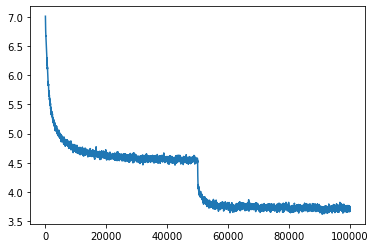

In [ ]:
# Test previous checkpoints
net = Darknet64()
state = torch.load(checkpoints + 'checkpoint-10.pkl')
net.load_state_dict(state['net'])
plt.plot(smooth(state['losses'],50))
print("Testing  accuracy: %f" % accuracy(net, data['test']))

## Transfer Learning To CIFAR-10

Now we can take our learned weights and use them as pretraining for the CIFAR-10 dataset.

### Loading The CIFAR Data

In [ ]:
def get_cifar10_data(augmentation=0):
  # Data augmentation transformations. Not for Testing!
  if augmentation:
    transform_train = transforms.Compose([
      transforms.RandomCrop(32, padding=4, padding_mode='edge'), # Take 32x32 crops from 40x40 padded images
      transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
      transforms.ToTensor(),
    ])
  else: 
    transform_train = transforms.ToTensor()

  transform_test = transforms.Compose([
    transforms.ToTensor(),
  ])

  trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True,
                                        transform=transform_train)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True,
                                            num_workers=2)

  testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True,
                                      transform=transform_test)
  testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False,
                                          num_workers=2)
  classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
  return {'train': trainloader, 'test': testloader, 'classes': classes}

cifar_data = get_cifar10_data(augmentation=1)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Defining The Model

The model is the same as our ImageNet model except the final fully connected layer only has 10 outputs instead of 1000.

In [ ]:
class Darknet64Cifar(nn.Module):
    def __init__(self):
        super(Darknet64Cifar, self).__init__() # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, 3, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 256, 3, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(256)

        self.fc10 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.bn4(self.conv4(x))), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.bn5(self.conv5(x))), kernel_size=2, stride=2)
        x = F.adaptive_avg_pool2d(x, 1)
        x = torch.flatten(x, 1)
        x = self.fc10(x)
        return x

### Training From Scratch

We can train a version of this model from scratch so we have a baseline. As with last tutorial it gets about 80% accuracy.

Learning rate: 0.010000
[0,   100] loss: 1.699
[0,   200] loss: 1.425
[0,   300] loss: 1.318
[1,   100] loss: 1.130
[1,   200] loss: 1.056
[1,   300] loss: 1.038
[2,   100] loss: 0.988
[2,   200] loss: 0.933
[2,   300] loss: 0.914
[3,   100] loss: 0.867
[3,   200] loss: 0.857
[3,   300] loss: 0.849
[4,   100] loss: 0.797
[4,   200] loss: 0.799
[4,   300] loss: 0.766
Learning rate: 0.001000
[5,   100] loss: 0.684
[5,   200] loss: 0.656
[5,   300] loss: 0.658
[6,   100] loss: 0.626
[6,   200] loss: 0.631
[6,   300] loss: 0.633
[7,   100] loss: 0.628
[7,   200] loss: 0.618
[7,   300] loss: 0.617
[8,   100] loss: 0.607
[8,   200] loss: 0.614
[8,   300] loss: 0.603
[9,   100] loss: 0.606
[9,   200] loss: 0.593
[9,   300] loss: 0.603
Learning rate: 0.000100
[10,   100] loss: 0.588
[10,   200] loss: 0.585
[10,   300] loss: 0.583
[11,   100] loss: 0.572
[11,   200] loss: 0.594
[11,   300] loss: 0.581
[12,   100] loss: 0.567
[12,   200] loss: 0.583
[12,   300] loss: 0.591
[13,   100] loss: 0.57

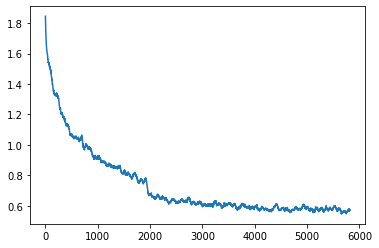

In [ ]:
cifar_net = Darknet64Cifar()
cifar_losses = train(cifar_net, cifar_data['train'], epochs=15, schedule={0:.01, 5:.001, 10:.0001}, print_every=100)
print("Testing accuracy: %f" % accuracy(cifar_net, cifar_data['test']))
plt.plot(smooth(cifar_losses,50))

### Training With Pretrained Weights

We can initialize our model with the weights from our last checkpoint of ImageNet training. The convolutional layers will be intialized as powerful feature extractors and the fully connected layer will still be randomly initialized.

Using the same training regime as above our model gets significantly higher accuracy.

In [ ]:
pretrain_net = Darknet64Cifar()

# Load weights from pretrained ImageNet model
state = torch.load(checkpoints + 'checkpoint-19.pkl')
output = pretrain_net.load_state_dict(state['net'], strict=False)


Learning rate: 0.010000
[0,   100] loss: 1.047
[0,   200] loss: 0.781
[0,   300] loss: 0.743
[1,   100] loss: 0.636
[1,   200] loss: 0.626
[1,   300] loss: 0.649
[2,   100] loss: 0.608
[2,   200] loss: 0.591
[2,   300] loss: 0.585
[3,   100] loss: 0.534
[3,   200] loss: 0.557
[3,   300] loss: 0.564
[4,   100] loss: 0.500
[4,   200] loss: 0.522
[4,   300] loss: 0.515
Learning rate: 0.001000
[5,   100] loss: 0.442
[5,   200] loss: 0.416
[5,   300] loss: 0.416
[6,   100] loss: 0.396
[6,   200] loss: 0.400
[6,   300] loss: 0.391
[7,   100] loss: 0.386
[7,   200] loss: 0.385
[7,   300] loss: 0.386
[8,   100] loss: 0.380
[8,   200] loss: 0.371
[8,   300] loss: 0.377
[9,   100] loss: 0.374
[9,   200] loss: 0.374
[9,   300] loss: 0.366
Learning rate: 0.000100
[10,   100] loss: 0.365
[10,   200] loss: 0.356
[10,   300] loss: 0.355
[11,   100] loss: 0.361
[11,   200] loss: 0.351
[11,   300] loss: 0.352
[12,   100] loss: 0.350
[12,   200] loss: 0.362
[12,   300] loss: 0.352
[13,   100] loss: 0.36

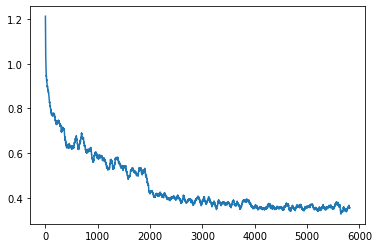

In [ ]:
pretrain_net = Darknet64Cifar()

# Load weights from pretrained ImageNet model
state = torch.load(checkpoints + 'checkpoint-19.pkl')
pretrain_net.load_state_dict(state['net'], strict=False)
# `strict=false` tells PyTorch to ignore discrepancies between saved network vs destination network

# Train as above
pretrain_losses = train(pretrain_net, cifar_data['train'], epochs=15, schedule={0:.01, 5:.001, 10:.0001}, print_every=100)
print("Testing accuracy: %f" % accuracy(pretrain_net, cifar_data['test']))
plt.plot(smooth(pretrain_losses,50))

### Comparing Training From Scratch And Pretraining

The pretrained model converges much faster to a lower final loss and better accuracy. You can play around with the training parameters to see if you can do even better!

Pretraining is a powerful technique because you can learn much faster on a new dataset. This means you don't have to train as long which makes it easier to train the classifier and makes it less likely to overfit to the data.

In general you can use smaller learning rates when fine-tuning on a new dataset (this will help with overfitting) but every dataset is different so play around a little and see what works for you!

Testing accuracy from scratch: 0.802500
Testing accuracy pretrained  : 0.858700


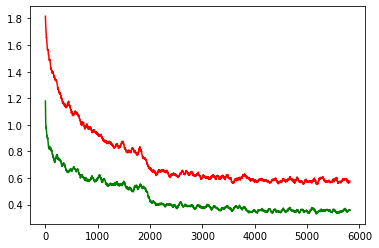

In [ ]:
print("Testing accuracy from scratch: %f" % accuracy(cifar_net, cifar_data['test']))
print("Testing accuracy pretrained  : %f" % accuracy(pretrain_net, cifar_data['test']))

plt.plot(smooth(cifar_losses,50), 'r-')
plt.plot(smooth(pretrain_losses,50),'g-')

## Transfer Learning With Resnet

In practice you wouldn't actually train the model yourself on ImageNet you would probably download a pretrained one. PyTorch has a number of model built in!

In [ ]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
print(model)


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### A "Bigger" Dataset

There's one problem with ResNet, it expects much bigger images than CIFAR normally has. That's fine, we'll just scale our dataset up a bit...

For most datasets you won't have to do this but you will have to make sure your dataset is defined so that you are processing images large enough for your model. I'm actually not sure how much downsampling resnet18 does but 128x128 should be sufficiently large, if it isn't I'll come back and fix it!

In [ ]:
def get_big_cifar10_data(augmentation=0):
  # Data augmentation transformations. Not for Testing!
  if augmentation:
    transform_train = transforms.Compose([
      transforms.Resize(128),
      transforms.RandomCrop(128, padding=8, padding_mode='edge'), # Take 128x128 crops from 136x136 padded images
      transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
      transforms.ToTensor(),
    ])
  else: 
    transform_train = transforms.ToTensor()

  transform_test = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
  ])

  trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True,
                                        transform=transform_train)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True,
                                            num_workers=2)

  testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True,
                                      transform=transform_test)
  testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False,
                                          num_workers=2)
  classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
  return {'train': trainloader, 'test': testloader, 'classes': classes}


### Fine Tuning ResNet on Big Cifar

Now we can load our data and model, reinitialize the last layer of the model to output 10 predictions instead of 1000, and train it!

**Note:** If you get a python error here that `train` isn't defined you have to scroll back up to the training code from earlier in the tutorial and make sure you run it. You'll also have to run the first cell in the notebook to do all the imports!

Files already downloaded and verified
Files already downloaded and verified


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


[0,   100] loss: 0.660
[0,   200] loss: 0.354
[0,   300] loss: 0.286
Testing accuracy: 0.908300


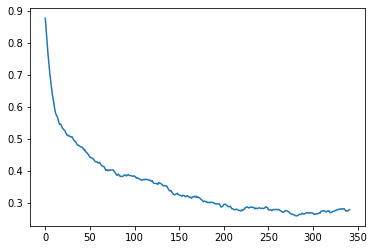

In [ ]:
big_cifar_data = get_big_cifar10_data(augmentation=1)
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
# Before
# resnet.fc = nn.Linear(512, 1000)
resnet.fc = nn.Linear(512, 10) # Reinitializes final layer, assigns random weights

resnet_losses = train(resnet, big_cifar_data['train'], epochs=1, lr=.01, print_every=100)
print("Testing accuracy: %f" % accuracy(resnet, big_cifar_data['test']))
plt.plot(smooth(resnet_losses,50))

We did it! After just 1 epoch of training ResNet18 gets almost 91% testing accuracy on CIFAR10. Not too shabby. However training does take considerably longer since the model is quite large and we have increased the size of the dataset as well (from 32x32 to 128x128).

In [ ]:
big_cifar_data = get_big_cifar10_data(augmentation=1)
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
# Before
# resnet.fc = nn.Linear(512, 1000)
resnet.fc = nn.Linear(512, 10) # Reinitializes final layer, assigns random weights

resnet_losses = train(resnet, big_cifar_data['train'], epochs=10, lr=.01, print_every=100)
print("Testing accuracy: %f" % accuracy(resnet, big_cifar_data['test']))
plt.plot(smooth(resnet_losses,50))